<a href="https://colab.research.google.com/github/hmgu-itg/VolosSummerSchool/blob/master/VSS_2023/7_Workshop_molQTL/7_Workshop_molQTL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QTL practical
*(Mauro Tutino, mauro.tutino@helmholtz-munich.de)*

-   In this workshop, we will familiarize ourselves with the basic implementation of QTL mapping. For the purposes of this practical we will use genotype and Gene expression data in human individuals.

-   **Note!** The data have already passed the necessary QC (Quality Control checks e.g.normalization) and are ready to be analysed.

*First we have to install several packages...*

In [1]:
# Install all the necessarry packages.
install.packages('dplyr')
install.packages('tidyr')
install.packages('ggplot2')
install.packages('magrittr')
#install.packages('factoextra')
#if (!requireNamespace('devtools', quietly = TRUE))
#install.packages('devtools')
#devtools::install_github('kevinblighe/PCAtools')
install.packages('IRdisplay')
install.packages('MatrixEQTL')
install.packages("corrplot")


Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages

Die heruntergeladenen Binärpakete sind in 
	/var/folders/jn/rn3xhrh561q2mglh5snf7clh6q2mgp/T//Rtmp09TU6Y/downloaded_packages


In [1]:
# Load the libraries.
library(dplyr)
library(tidyr)
library(ggplot2)
library(magrittr)
#library(PCAtools)
library(IRdisplay)
library(MatrixEQTL)
library(corrplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract


corrplot 0.92 loaded



In [2]:
getwd()

[1] "/Users/mauro.tutino/Documents/Work/molQTL_lectureWorkshop"

In [3]:
# Unzip the Data & dependencies.
system('unzip Data_and_dependencies.zip', intern = T)

system('ls', intern = T)

Warning message in system("unzip Data_and_dependencies_MT.zip", intern = T):
“running command 'unzip Data_and_dependencies_MT.zip' had status 1”


[1] "Archive:  Data_and_dependencies_MT.zip"
attr(,"status")
[1] 1
attr(,"errmsg")
[1] "Resource temporarily unavailable"

[1] "7_Workshop_molQTL_MT.ipynb"   "Data_and_dependencies_MT"    
[3] "Data_and_dependencies_MT.zip" "Lecture7_molQTL_MT.pdf"      
[5] "__MACOSX"


- A quick overview of the things we are going to cover.

[1] "/Users/mauro.tutino/Documents/Work/molQTL_lectureWorkshop/Data_and_dependencies_MT"

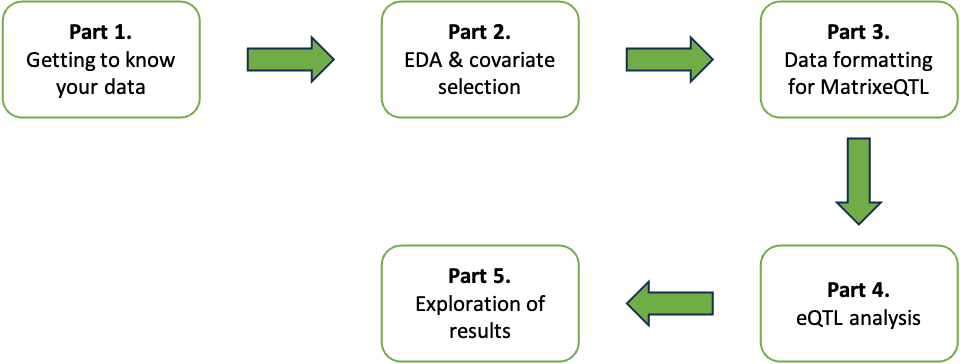

In [7]:
setwd('Data_and_dependencies') # Set the working directory
getwd()

display_png(file = 'workflow.png')

---
### Part 1. Getting to know your data

-   First, we are going to load all the necessary files:
  - What we need :
      - a.  Genotypes
      - b.  Gene Expression data
      - c.  Info for Genes and SNPs (position, chromosome etc.)

In [9]:
snps = read.table('input/uniq.snps.txt', header = T) # Genotype info - it has been converted to dosage matrix.

snps <- snps %>% 
        select(snp, everything()) # Re-arrange the columns.
head(snps)
dim(snps)

,snp,GM_157,GM_160,GM_162,GM_165,GM_170,GM_175,GM_179,GM_182,GM_184,⋯,GM_228,GM_229,GM_232,GM_234,GM_235,GM_239,GM_244,GM_246,GM_247,GM_248
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2,1_751567_G_A,1,1,2,1,2,2,1,2,1,⋯,2,1,1,1,2,2,2,2,1,1
3,1_751796_G_A,1,1,2,1,2,2,1,2,1,⋯,2,1,1,1,2,2,2,2,1,1
4,1_752038_G_T,0,1,0,0,0,0,1,0,1,⋯,0,1,1,0,0,0,0,0,0,0
5,1_752311_T_A,1,0,0,1,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,1,1
6,1_752313_T_G,0,1,0,0,0,0,1,0,1,⋯,0,1,1,0,0,0,0,0,0,0
7,1_752361_T_C,0,1,0,0,0,0,1,0,1,⋯,0,1,1,0,0,0,0,0,0,0


[1] 426747     94

In [10]:
# b.
ge = read.table('input/ge.profile.txt', header = T) # Gene expression data (RPKM values).
rownames(ge) <- ge$IID
head(ge)

,IID,ENSG00000227232.4,ENSG00000268903.1,ENSG00000269981.1,ENSG00000237683.5,ENSG00000228463.4,ENSG00000225972.1,ENSG00000225630.1,ENSG00000237973.1,ENSG00000229344.1,⋯,ENSG00000232347.1,ENSG00000162714.8,ENSG00000162711.12,ENSG00000177535.6,ENSG00000227135.1,ENSG00000264500.1,ENSG00000175137.9,ENSG00000171161.8,ENSG00000171163.11,ENSG00000185220.7
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GM_155,GM_155,2.7144297,0.2569999,1.024832,1.057312,0.6134134,3.129595,4.460573,875.67218,2.133815,⋯,0.1374185,4.514154,0.8361816,0.09204693,0.2961461,0.000000,5.617739,5.497915,8.608974,1.9033118
GM_157,GM_157,0.6364987,0.8738158,2.613371,1.874940,0.2815620,5.652937,5.845317,24.74525,1.874236,⋯,0.1752118,3.147990,1.8722660,0.15648270,0.3775933,0.000000,4.269858,5.477918,5.808081,1.4429430
GM_158,GM_158,0.8767443,1.2036360,1.199928,2.945483,0.3160154,6.107161,2.611338,30.18354,1.998707,⋯,0.1608969,2.858436,4.6325580,0.75441390,0.6241384,1.695421,4.646045,5.404862,5.285419,1.2045940
GM_160,GM_160,1.6056800,1.4695690,3.472691,3.042247,0.3741442,6.407052,291.433200,30.46725,1.205088,⋯,0.5238549,3.070989,8.2152460,0.97470360,0.4515770,0.000000,2.776078,6.184347,4.994329,1.3291110
GM_162,GM_162,1.1217738,1.2320197,1.501162,1.835181,0.4116859,3.229774,3.823755,16.12584,1.648037,⋯,0.7685581,2.940563,5.5809838,0.11031485,0.5205496,0.000000,3.960035,5.946721,3.882627,1.0788746
GM_163,GM_163,1.1682910,0.9434624,1.504889,2.382411,0.4143456,3.446681,3.889071,19.20432,1.775563,⋯,0.2017887,2.773229,5.3008030,0.00000000,0.2609209,0.000000,4.495610,4.893471,5.306586,0.9819813


In [11]:
# c.
snp.loc = read.table('input/snps.loc.txt', header = T) # Location info for SNPs.
head(snp.loc)
gene.loc = read.table('input/gene.loc.txt', header = T) # Location info for Genes.
head(gene.loc)

,SNP_ID,chr,pos
,<chr>,<int>,<int>
1,1_751567_G_A,1,751567
2,1_751796_G_A,1,751796
3,1_752038_G_T,1,752038
4,1_752311_T_A,1,752311
5,1_752313_T_G,1,752313
6,1_752361_T_C,1,752361


,gene,chr,start,end
,<chr>,<int>,<int>,<int>
1,ENSG00000227232.4,1,29805,29806
2,ENSG00000268903.1,1,135894,135895
3,ENSG00000269981.1,1,137964,137965
4,ENSG00000237683.5,1,139378,139379
5,ENSG00000228463.4,1,267252,267253
6,ENSG00000225972.1,1,564441,564442


---
#### Questions Part 1.

  1.  How many Samples, SNPs and Genes do we have ?
  2.  On which chromosome are the SNPs and Genes located ?

In [ ]:
# 1. TYPE YOUR RESPONSE HERE

In [12]:
#@title
# 1. How many Samples, SNPs and Genes do we have?
cat('Number of Genes:', ncol(ge)-1, '\n' );
cat('Number of samples:', ncol(snps)-1, '\n');
cat('Number of SNPs:', nrow(snps), '\n')

Number of Genes: 2145 
Number of samples: 93 
Number of SNPs: 426747 


In [ ]:
# 2. TYPE YOUR RESPONSE HERE

In [13]:
# 2. On which chromosome are the SNPs and Genes located ?
cat('Chromosome of SNPs:', unique(snp.loc$chr), '\n')
cat('Chromosome of Genes:', unique(gene.loc$chr), '\n')

Chromosome of SNPs: 1 
Chromosome of Genes: 1 


---
### Part 2. Covariate selection

- Although the data have passed the necessary QC steps, we will check for  outlier individuals/observations for both Genotype and GE data.
A common practice to do this -in high dimensional data- is via Principal Component Analysis (PCA).

*-Outlier observations can inflate false positive findings.*

- We will start with the PCA of genotypes. After computing the Principal Components (PCs) we are going to plot the first two of them.

*-By definition the first PC captures the majority of variance in the variables of interest.*

NOTE: here we use the R function prcomp() to calculate the PCs. Usually this is done with specialised software such as Plink

Importance of components:
                            PC1      PC2      PC3      PC4      PC5      PC6
Standard deviation     80.15163 79.19060 78.44150 77.74291 77.53770 77.06669
Proportion of Variance  0.01505  0.01470  0.01442  0.01416  0.01409  0.01392
Cumulative Proportion   0.01505  0.02975  0.04417  0.05833  0.07242  0.08634
                            PC7      PC8     PC9    PC10     PC11     PC12
Standard deviation     76.75773 76.01029 75.9001 75.6238 75.36949 75.13831
Proportion of Variance  0.01381  0.01354  0.0135  0.0134  0.01331  0.01323
Cumulative Proportion   0.10014  0.11368  0.1272  0.1406  0.15389  0.16712
                           PC13     PC14     PC15     PC16     PC17     PC18
Standard deviation     74.54645 74.34079 74.17507 73.88891 73.43186 73.28440
Proportion of Variance  0.01302  0.01295  0.01289  0.01279  0.01264  0.01258
Cumulative Proportion   0.18015  0.19310  0.20599  0.21878  0.23142  0.24400
                           PC19     PC20     PC21     PC22

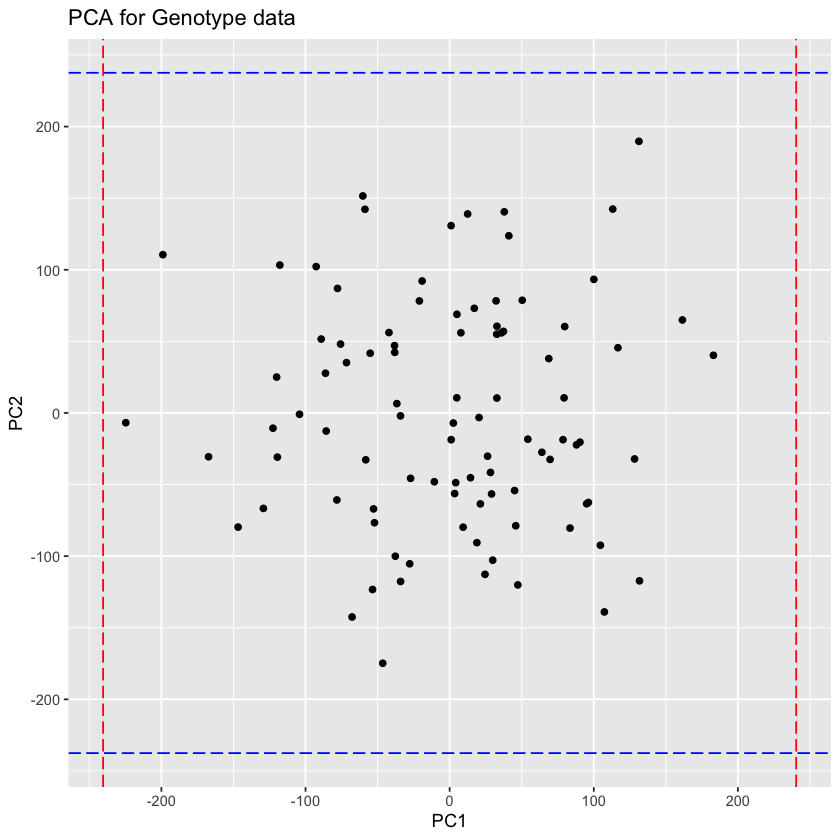

In [14]:
# PCA for genotypes via prcomp in R.
geno.pca <- prcomp(t(snps[,-1]), scale. = T) # Remember to include only the variables. NB we have to transpose the data frame since the package needs the variables as columns and subjects as rows!
summary(geno.pca) # Take a look at the output

# Visual inspection of PCs, plotting the first 2 PCs.
pca.data <-  data.frame(PC1=geno.pca$x[,1], PC2=geno.pca$x[,2])

cat('', '\n')
PC1.sd <-  sd(pca.data$PC1)
PC2.sd <-  sd(pca.data$PC2)

ggplot(data=pca.data, aes(x=PC1, y=PC2)) +
  geom_point() +
  geom_vline(xintercept = mean(pca.data$PC1) - 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_vline(xintercept = mean(pca.data$PC1) + 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) - 3*PC2.sd, colour="blue", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) + 3*PC2.sd, colour="blue", linetype = "longdash") +
  ggtitle('PCA for Genotype data')



In [15]:
# Here we can access the Principal Component scores for each individual
head(geno.pca$x)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,⋯,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93
GM_157,64.00485,-27.46770,55.18358,-53.44543,63.71092,-112.05592,41.23572,-64.4550173,168.79842,-25.57781,⋯,12.668015,2.8620665,-21.1932659,13.471539,-12.050079,77.01372,-44.21061,4.420471,-31.019138,-6.309813e-11
GM_160,107.35613,-138.97461,80.93546,66.43073,-115.53709,26.21996,-50.76847,9.3741455,-45.48960,19.99871,⋯,-14.803808,-10.0091429,-28.7077375,-17.491813,-30.080227,-29.42999,-57.99224,-8.275115,142.778358,-6.774935e-11
GM_162,68.80517,37.95872,30.98546,70.79472,136.03791,58.27910,56.92433,-74.0861580,50.41598,33.75465,⋯,-18.572600,44.4379337,26.8511477,-1.551683,-32.695342,-21.13947,-81.64659,-11.368358,-29.902950,-1.180743e-10
GM_165,-67.70721,-142.50178,-88.31706,-17.58449,19.18650,41.22948,-110.04727,-0.2530265,23.16212,43.90609,⋯,-48.388517,-28.7833700,-86.2609113,-81.707874,15.073367,-63.27570,61.33035,-71.729984,3.897521,-1.471625e-11
GM_170,32.69598,54.98895,25.17099,19.42276,36.19937,23.34080,51.29447,2.2441627,35.18580,-15.15089,⋯,-9.246709,0.8426894,0.2598799,96.105372,-144.224977,45.18929,65.00282,8.468714,-40.795169,9.905573e-12
GM_175,-77.78896,86.97585,13.34320,-177.66115,49.77865,-30.04046,-178.93171,177.8192278,83.97115,-27.37498,⋯,-22.340569,-5.7384508,-55.2418075,11.011341,-4.846047,76.56605,-54.90220,28.494085,43.795577,1.379661e-11


- The points in the scatter plot are randomly scattered, no indication of clustering.

Next, we are going to produce the same plot for the GE data...

Importance of components:
                           PC1      PC2      PC3      PC4      PC5     PC6
Standard deviation     18.4841 14.41268 11.82733 11.74576 10.26156 9.44405
Proportion of Variance  0.1593  0.09684  0.06521  0.06432  0.04909 0.04158
Cumulative Proportion   0.1593  0.25613  0.32134  0.38566  0.43475 0.47633
                           PC7     PC8     PC9    PC10    PC11   PC12    PC13
Standard deviation     8.15333 7.87432 7.10285 6.70833 6.39582 5.7473 5.60720
Proportion of Variance 0.03099 0.02891 0.02352 0.02098 0.01907 0.0154 0.01466
Cumulative Proportion  0.50732 0.53623 0.55975 0.58073 0.59980 0.6152 0.62985
                          PC14    PC15    PC16    PC17   PC18    PC19    PC20
Standard deviation     5.51228 5.13066 5.06818 4.80858 4.7237 4.62488 4.45347
Proportion of Variance 0.01417 0.01227 0.01198 0.01078 0.0104 0.00997 0.00925
Cumulative Proportion  0.64402 0.65629 0.66827 0.67905 0.6895 0.69942 0.70867
                          PC21    PC22   PC23    P

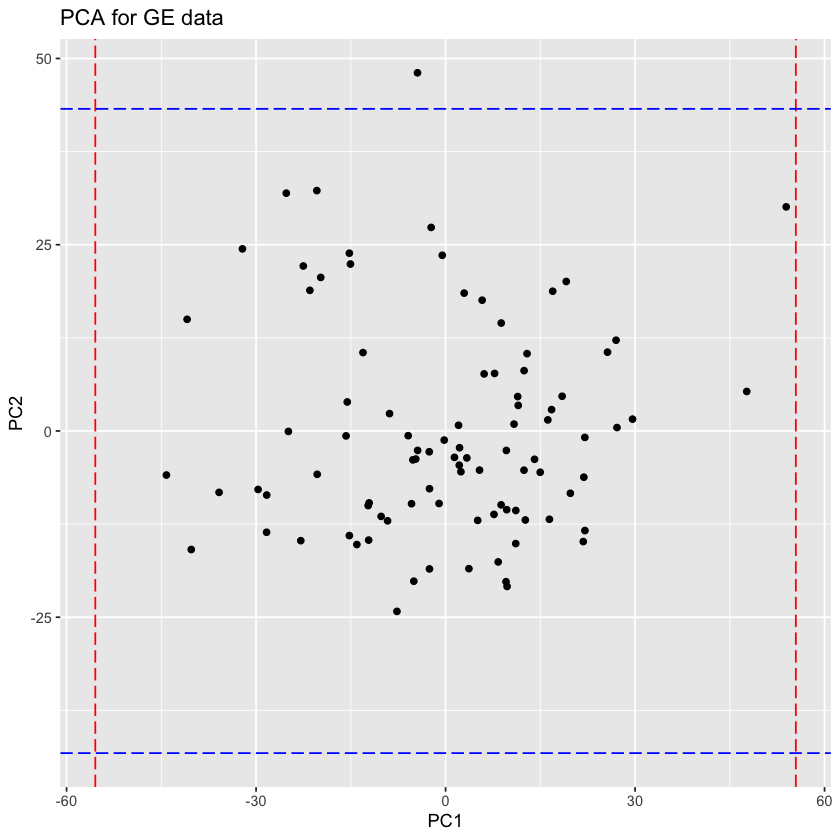

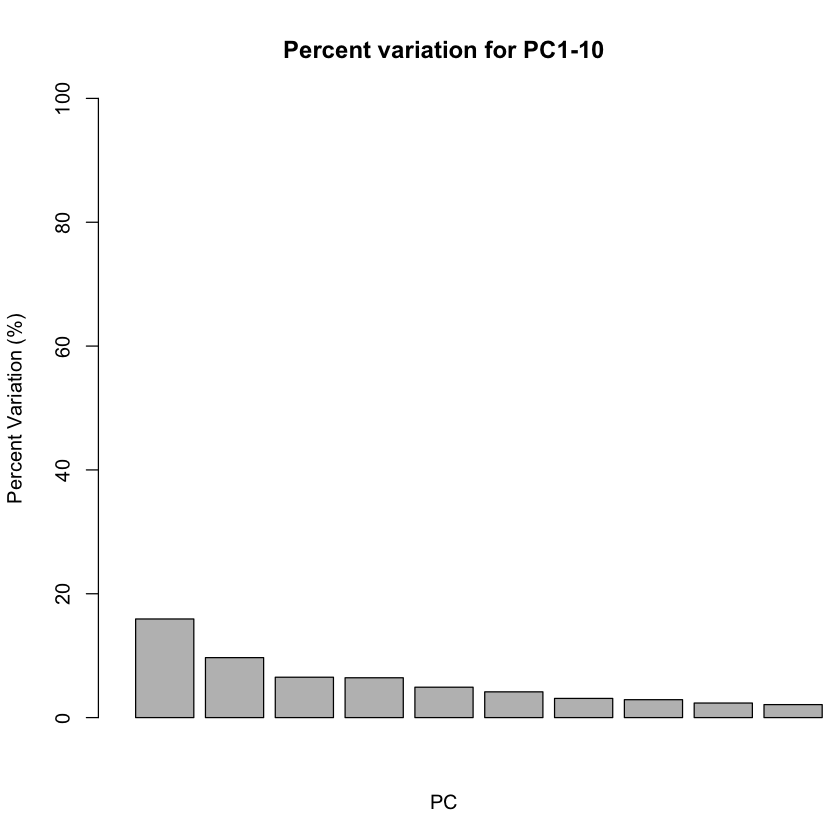

In [17]:
# The same procedure as above.
ge.pca = prcomp(ge[,-1], scale = T) # No need to transpose the data frame.
summary(ge.pca)

# PCA data.frame
pca.data = data.frame(PC1=ge.pca$x[,1], PC2=ge.pca$x[,2])

PC1.sd = sd(pca.data$PC1)
PC2.sd = sd(pca.data$PC2)

# Visual inspection of PCs.
ggplot(data=pca.data, aes(x=PC1, y=PC2)) +
  geom_point() +
  geom_vline(xintercept = mean(pca.data$PC1) - 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_vline(xintercept = mean(pca.data$PC1) + 3*PC1.sd, colour="red", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) - 3*PC2.sd, colour="blue", linetype = "longdash") +
  geom_hline(yintercept = mean(pca.data$PC2) + 3*PC2.sd, colour="blue", linetype = "longdash") +
  ggtitle('PCA for GE data')

# Variation explained for each PC.
pca.object.var <- summary(ge.pca)
pca.object.var.per <- as.numeric(pca.object.var$importance[2,])*100

barplot(pca.object.var.per[1:10], main="Percent variation for PC1-10",
        xlab = "PC",
        ylab = "Percent Variation (%)",
        xlim = c(0, 11),
        ylim = c(0,100))



#### Questions Part 2.

  1. What do you think of the PCA plot in GE data ? Any outliers ?
  2. How much variation do the first 3 components explain in GE data ?


In [ ]:
#.1 TYPE YOUR RESPONSE HERE

# As we can see there is one point that falls outside the bondaries but it is still very close.
# Even if we are going to exclude this observation it is unlikely that this will influence the behaviour of the other points.

In [ ]:
#.2 TYPE YOUR RESPONSE HERE

In [18]:
# 2. How much variation the first 3 components explain in GE data ?

pca.object.var$importance[3,3]*100


[1] 32.134

- Except for outlier detection, PCA, can also be used for: 
    - covariate selection
    - account for unknown covariates

*-Recall from the previous lectures that when we are modelling the effect of a variable on an outcome of interest, in our case the genetic effect of SNP on GE, we have to control for additional factors that may confound the relationship that we are investigating.*

- We hold data for Age, Sex and BMI for each participant, go ahead and load the data.

In [19]:
# Load the covariates.
age = read.table('input/Age.txt', header = F)
age = age[,c(1,3)] # Drop the duplicated column.
colnames(age) <- c('IID','age')

sex = read.table('input/Sex.txt', header = F)
sex = sex[,c(1,3)] # Drop the duplicated column.
colnames(sex) <- c('IID','sex')

bmi = read.table('input/BMI.txt', header = F)
bmi = bmi[,c(1,3)] # Drop the duplicated column.
colnames(bmi) <- c('IID','bmi')

[1] TRUE

,IID,age,sex,bmi,PC1,PC2,PC3
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,GM_155,78,1,27.34,-40.259065,-15.9082062,-9.699287
2,GM_157,40,2,24.49,-5.183375,-3.8778294,3.129487
3,GM_158,85,1,20.20,-8.869428,2.3314854,-17.878814
4,GM_160,68,2,24.77,2.943372,18.5047945,2.332016
5,GM_162,71,2,27.68,-5.920532,-0.6318436,5.251768
6,GM_163,31,1,46.56,-2.547293,-7.7481073,-9.776813


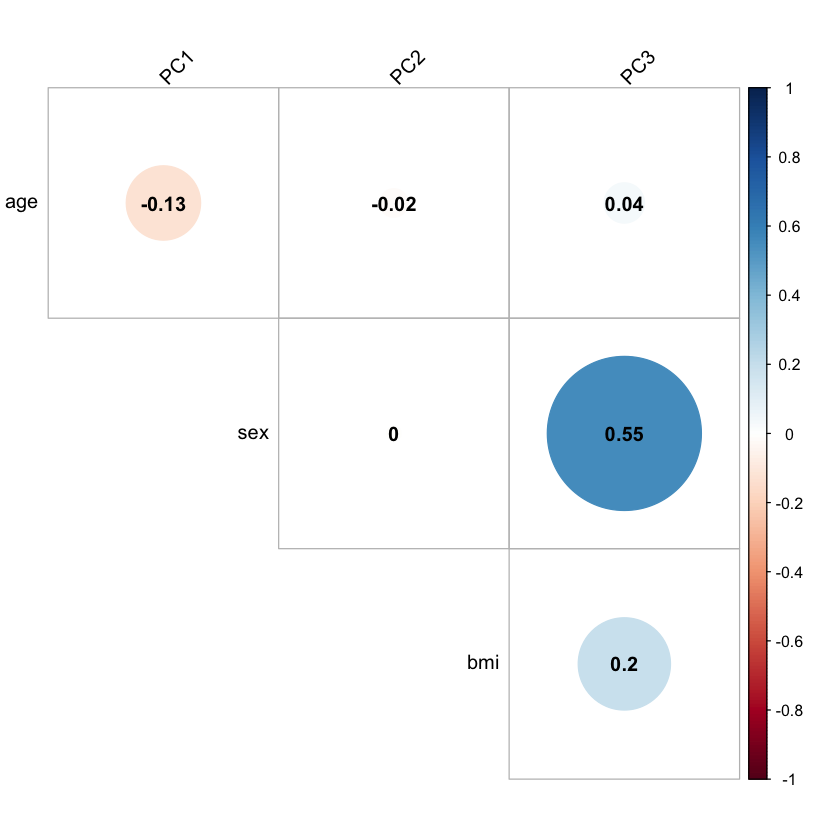

In [20]:
# Correlation plot of PCs with covariates

# Do the the PCs of GE correlate with the observed covariates/factors ?
metadata = merge(age, sex, by = 'IID')
metadata = merge(metadata, bmi, by = 'IID')

matching.ind <- ge$IID # Make sure that we have the same order in SampleIDs between dataframes.

metadata <- metadata[match(matching.ind, metadata$IID),] # Tricky the first argument of match defines the order of matching values.

identical(ge$IID, metadata$IID) # Sanity check.

# Data manipulation to meet the need of PCAtools.
t.ge <- t(as.matrix(ge))
colnames(t.ge) <- t.ge[1,]
t.ge <- t.ge[-1,]
rownames(t.ge) <- NULL
t.ge <- data.frame(t.ge)
t.ge[,] <- sapply(t.ge, as.numeric)

rownames(metadata) <- metadata$IID

ge.pca_3PC <- as.data.frame(ge.pca$x[,c(1:3)])
ge.pca_3PC$IID <- rownames(ge.pca_3PC)

metadata <- merge(metadata, ge.pca_3PC, by = 'IID')
metadata$sex <- as.numeric(as.factor(metadata$sex)) # convert sex to numerical for correlation

head(metadata)

# Calculate correlation. We are not interested in the correlation between unknown covariates
cor.res <- cor(metadata[,2:4], metadata[,5:7])

# Plot correlation
corrplot(cor.res, type = "upper", order = "original", 
         tl.col = "black", tl.srt = 45, addCoef.col = 'black')

# Positive correlations are displayed in blue and negative correlations in red color. 
# Color intensity and the size of the circle are proportional to the correlation coefficients. 
# In the right side of the correlogram, the legend color shows the correlation coefficients and the corresponding colors.

- Only PC3 shows a moderate correlation with sex

---
### Part 3. Data formatting for MatrixEQTL

MatrixEQTL is a tool specialized for genetic association analyses with molecular traits (Gene Expression data, Metabolites etc.). Instead of doing single-point associations, like for GWAS tools, it performs matrix operations, which allows to run thousands of associations at once. It also allows to run cis and trans QTL separately.


In this section we are going to prepare the input files for MatrixEQTL


In [21]:
# Format the gene expression data - samples need to be on columns
dim(ge)
ge[1:5,1:5]

ge <- t(ge)

colnames(ge) <- ge[1,]
ge <- ge[-1,]

ge[1:5,1:5]

[1]   93 2146

,IID,ENSG00000227232.4,ENSG00000268903.1,ENSG00000269981.1,ENSG00000237683.5
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
GM_155,GM_155,2.7144297,0.2569999,1.024832,1.057312
GM_157,GM_157,0.6364987,0.8738158,2.613371,1.874940
GM_158,GM_158,0.8767443,1.2036360,1.199928,2.945483
GM_160,GM_160,1.6056800,1.4695690,3.472691,3.042247
GM_162,GM_162,1.1217738,1.2320197,1.501162,1.835181


,GM_155,GM_157,GM_158,GM_160,GM_162
ENSG00000227232.4,2.7144297,0.6364987,0.8767443,1.6056800,1.1217738
ENSG00000268903.1,0.2569999,0.8738158,1.2036360,1.4695690,1.2320197
ENSG00000269981.1,1.0248323,2.6133710,1.1999280,3.4726910,1.5011624
ENSG00000237683.5,1.0573117,1.8749400,2.9454830,3.0422470,1.8351815
ENSG00000228463.4,0.61341338,0.28156200,0.31601540,0.37414420,0.41168588


In [22]:
# Format genotype data - samples need to be on columns
dim(snps)
snps[1:5,1:5]

rownames(snps) <- snps[,1]
snps <- snps[,-1]

snps[1:5,1:5]


[1] 426747     94

,snp,GM_157,GM_160,GM_162,GM_165
,<chr>,<int>,<int>,<int>,<int>
2,1_751567_G_A,1,1,2,1
3,1_751796_G_A,1,1,2,1
4,1_752038_G_T,0,1,0,0
5,1_752311_T_A,1,0,0,1
6,1_752313_T_G,0,1,0,0


,GM_157,GM_160,GM_162,GM_165,GM_170
,<int>,<int>,<int>,<int>,<int>
1_751567_G_A,1,1,2,1,2
1_751796_G_A,1,1,2,1,2
1_752038_G_T,0,1,0,0,0
1_752311_T_A,1,0,0,1,0
1_752313_T_G,0,1,0,0,0


In [23]:
# Format covariates data - samples need to be on columns

covariates = merge(age, sex, by = 'IID')
covariates = merge(covariates, bmi, by = 'IID')

# we need to convert sex to numeric, F==0 and M==1
covariates <- covariates %>%
                mutate(sex = case_when(
                sex == "F" ~ "0",
                sex == "M" ~ "1",
                TRUE ~ sex),
                sex = as.numeric(sex)) %>% # Add the first three genotype principal components
                left_join(.,
                         as.data.frame(geno.pca$x) %>%
                          dplyr::select(1:3) %>%
                          mutate(IID = rownames(.)),
                         by='IID')



# Transpose and format
covariates <- t(covariates)
colnames(covariates) <- covariates[1,]
covariates <- covariates[-1,]

covariates[,1:5]


,GM_155,GM_157,GM_158,GM_160,GM_161
age,78,40,85,68,39
sex,0,1,0,1,0
bmi,27.34,24.49,20.20,24.77,45.97
PC1,-58.2173378,64.0048525,116.7637520,107.3561269,NA
PC2,-32.7227555,-27.4677021,45.5626625,-138.9746084,NA
PC3,99.26531217,55.18358435,-42.51464392,80.93545998,NA


In [24]:
# Check that the samples are in the right order between the files
index <- colnames(snps)

ge <- ge[,match(index, colnames(ge))]
covariates <- covariates[,match(index, colnames(covariates))]

ge[1:5,1:5]
covariates[,1:5]
snps[1:5,1:5]

identical(colnames(ge), colnames(snps))
identical(colnames(ge), colnames(covariates))


,GM_157,GM_160,GM_162,GM_165,GM_170
ENSG00000227232.4,0.6364987,1.6056800,1.1217738,0.9975918,0.9707744
ENSG00000268903.1,0.8738158,1.4695690,1.2320197,0.2536188,0.3969820
ENSG00000269981.1,2.6133710,3.4726910,1.5011624,0.8090797,1.2061220
ENSG00000237683.5,1.8749400,3.0422470,1.8351815,0.5900616,0.8367163
ENSG00000228463.4,0.28156200,0.37414420,0.41168588,0.23245180,0.08663095


,GM_157,GM_160,GM_162,GM_165,GM_170
age,40,68,71,52,27
sex,1,1,1,1,1
bmi,24.49,24.77,27.68,37.29,29.07
PC1,64.0048525,107.3561269,68.8051681,-67.7072087,32.6959842
PC2,-27.4677021,-138.9746084,37.9587184,-142.5017840,54.9889480
PC3,55.18358435,80.93545998,30.98545606,-88.31705501,25.17098925


,GM_157,GM_160,GM_162,GM_165,GM_170
,<int>,<int>,<int>,<int>,<int>
1_751567_G_A,1,1,2,1,2
1_751796_G_A,1,1,2,1,2
1_752038_G_T,0,1,0,0,0
1_752311_T_A,1,0,0,1,0
1_752313_T_G,0,1,0,0,0


[1] TRUE

[1] TRUE

In [25]:
# write files to disk
write.table(ge, file="input/ge_matrixEQTL.txt", quote = FALSE, sep = "\t", row.names = TRUE, col.names = TRUE)
write.table(snps, file="input/snps_matrixEQTL.txt", quote = FALSE, sep = "\t", row.names = TRUE, col.names = TRUE)
write.table(covariates, file="input/covariates_matrixEQTL.txt", quote = FALSE, sep = "\t", row.names = TRUE, col.names = TRUE)



In [26]:
# we need to provide the snp and gene positions in the format snp	chr	pos and geneid	chr	s1	s2
snp.loc = read.table('input/snps.loc.txt', header = TRUE, ) # Location info for SNPs.
head(snp.loc)
gene.loc = read.table('input/gene.loc.txt', header = TRUE) # Location info for Genes.
head(gene.loc)

dim(snp.loc)
dim(snps)

,SNP_ID,chr,pos
,<chr>,<int>,<int>
1,1_751567_G_A,1,751567
2,1_751796_G_A,1,751796
3,1_752038_G_T,1,752038
4,1_752311_T_A,1,752311
5,1_752313_T_G,1,752313
6,1_752361_T_C,1,752361


,gene,chr,start,end
,<chr>,<int>,<int>,<int>
1,ENSG00000227232.4,1,29805,29806
2,ENSG00000268903.1,1,135894,135895
3,ENSG00000269981.1,1,137964,137965
4,ENSG00000237683.5,1,139378,139379
5,ENSG00000228463.4,1,267252,267253
6,ENSG00000225972.1,1,564441,564442


[1] 426747      3

[1] 426747     93

---
### Part 4. Association analysis - QTL mapping
- We are going to perform a cis-association analysis on chromosome1. That is, only the variants that fall inside a +/- 1Mb window from the TSS of the gene of interest are going to be tested.

  - Recall that we are using a linear regression model to estimate the genetic effect of each variant for the expression of each Gene.



In [27]:
## Genotype file name
SNP_file_name = "input/snps_matrixEQTL.txt" # dosage of alt allele. Samples on columns

### Gene expression file name
expression_file_name = "input/ge_matrixEQTL.txt"

## Covariates file name
covariates_file_name = "input/covariates_matrixEQTL.txt"




In [28]:
######----------------------------- set up parameters 

# Error covariance matrix
# Set to numeric() for identity.
errorCovariance = numeric();

# Output file names
transFileName = "eQTL_trans.txt"
cisFileName = "eQTL_cis.txt"

# Distance for local gene-SNP pairs
cisDist = 1e6

# model to use: modelANOVA, modelLINEAR, or modelLINEAR_CROSS
useModel = modelLINEAR

cis.thresh = 5e-8 # Save cis results with p-value < 5e-8
trans.thresh = 0 # Don't perform trans eQTL analysis. Change this to anything > 0 if you want to perfom trans analysis. NB it is lots of tests!

  

In [29]:
######----------------------------- load files

## Load genotype data
geno = SlicedData$new();
geno$fileDelimiter = "\t";      # the TAB character
geno$fileOmitCharacters = "NA"; # denote missing values;
geno$fileSkipRows = 1;          # one row of column labels
geno$fileSkipColumns = 1;       # one column of row labels
geno$fileSliceSize = 2000;      # read file in slices of 5,000 rows
geno$LoadFile(SNP_file_name);


## Load gene expression data
gene = SlicedData$new();
gene$fileDelimiter = "\t";      # the tab character
gene$fileOmitCharacters = "NA"; # denote missing values;
gene$fileSkipRows = 1;          # one row of column labels
gene$fileSkipColumns = 1;       # one column of row labels
gene$fileSliceSize = 2000;      # read file in slices of 2,000 rows
gene$LoadFile(expression_file_name);
  
## Load covariates
cvrt = SlicedData$new();
cvrt$fileDelimiter = "\t";      # the comma character
cvrt$fileOmitCharacters = "NA"; # denote missing values;
cvrt$fileSkipRows = 1;          # one row of column labels
cvrt$fileSkipColumns = 1;       # one column of row labels
#If loading from file
if(length(covariates_file_name)>0) {
 cvrt$LoadFile(covariates_file_name);
}
  
  

Rows read: 2,000

Rows read: 4,000

Rows read: 6,000

Rows read: 8,000

Rows read: 10,000

Rows read: 12,000

Rows read: 14,000

Rows read: 16,000

Rows read: 18,000

Rows read: 20,000

Rows read: 22,000

Rows read: 24,000

Rows read: 26,000

Rows read: 28,000

Rows read: 30,000

Rows read: 32,000

Rows read: 34,000

Rows read: 36,000

Rows read: 38,000

Rows read: 40,000

Rows read: 42,000

Rows read: 44,000

Rows read: 46,000

Rows read: 48,000

Rows read: 50,000

Rows read: 52,000

Rows read: 54,000

Rows read: 56,000

Rows read: 58,000

Rows read: 60,000

Rows read: 62,000

Rows read: 64,000

Rows read: 66,000

Rows read: 68,000

Rows read: 70,000

Rows read: 72,000

Rows read: 74,000

Rows read: 76,000

Rows read: 78,000

Rows read: 80,000

Rows read: 82,000

Rows read: 84,000

Rows read: 86,000

Rows read: 88,000

Rows read: 90,000

Rows read: 92,000

Rows read: 94,000

Rows read: 96,000

Rows read: 98,000

Rows read: 100,000

Rows read: 102,000

Rows read: 104,000

Rows read: 10

In [30]:
#######---------- run matrixeQTL
me = Matrix_eQTL_main(
    snps = geno, 
    gene = gene, 
    cvrt = cvrt,
    output_file_name     = file.path("output", transFileName),
    output_file_name.cis = file.path("output", cisFileName),
    pvOutputThreshold     = trans.thresh,
    pvOutputThreshold.cis = cis.thresh,
    useModel = useModel, 
    errorCovariance = numeric(),
    verbose = FALSE, 
    snpspos = snp.loc, 
    genepos = gene.loc,
    cisDist = cisDist,
    pvalue.hist = "qqplot",
    min.pv.by.genesnp = TRUE,
    noFDRsaveMemory = TRUE);




2145 of 2145 genes matched

426747 of 426747 SNPs matched


 0.23% done, 51 cis-eQTLs

 0.70% done, 51 cis-eQTLs

 1.16% done, 51 cis-eQTLs

 1.63% done, 51 cis-eQTLs

 2.10% done, 51 cis-eQTLs

 2.57% done, 51 cis-eQTLs

 3.03% done, 51 cis-eQTLs

 3.50% done, 51 cis-eQTLs

 3.97% done, 51 cis-eQTLs

 4.43% done, 51 cis-eQTLs

 4.90% done, 51 cis-eQTLs

 5.37% done, 51 cis-eQTLs

 5.84% done, 51 cis-eQTLs

 6.30% done, 51 cis-eQTLs

 6.77% done, 51 cis-eQTLs

 7.24% done, 56 cis-eQTLs

 7.71% done, 56 cis-eQTLs

 8.17% done, 56 cis-eQTLs

 8.64% done, 56 cis-eQTLs

 9.11% done, 56 cis-eQTLs

 9.57% done, 143 cis-eQTLs

10.04% done, 179 cis-eQTLs

10.51% done, 179 cis-eQTLs

10.98% done, 179 cis-eQTLs

11.44% done, 179 cis-eQTLs

11.91% done, 179 cis-eQTLs

12.38% done, 179 cis-eQTLs

12.85% done, 179 cis-eQTLs

13.31% done, 179 cis-eQTLs

13.78% done, 179 cis-eQTLs

14.25% done, 179 cis-eQTLs

14.71% done, 179 cis-eQTLs

15.18% done, 179 cis-eQTLs

15.65% done, 186 cis-eQTLs

16.12% d

[1] "list"       "MatrixEQTL"

[1] "time.in.sec" "param"       "cis"

[1] "ntests"      "neqtls"      "hist.bins"   "hist.counts" "min.pv.snps"
[6] "min.pv.gene"

Warning message in title(...):
“Fontmetrik ist für das Unicode-Zeichen U+2013 unbekannt”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <80>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <93>”
Warning message in title(...):
“Fontmetrik ist für das Unicode-Zeichen U+2013 unbekannt”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <80>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <93>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <e2>”
Warning message in title(...):
“Konvertierungsfehler für '– log' in 'mbcsToSbcs': Punkt ersetzt <80>”
Warnin

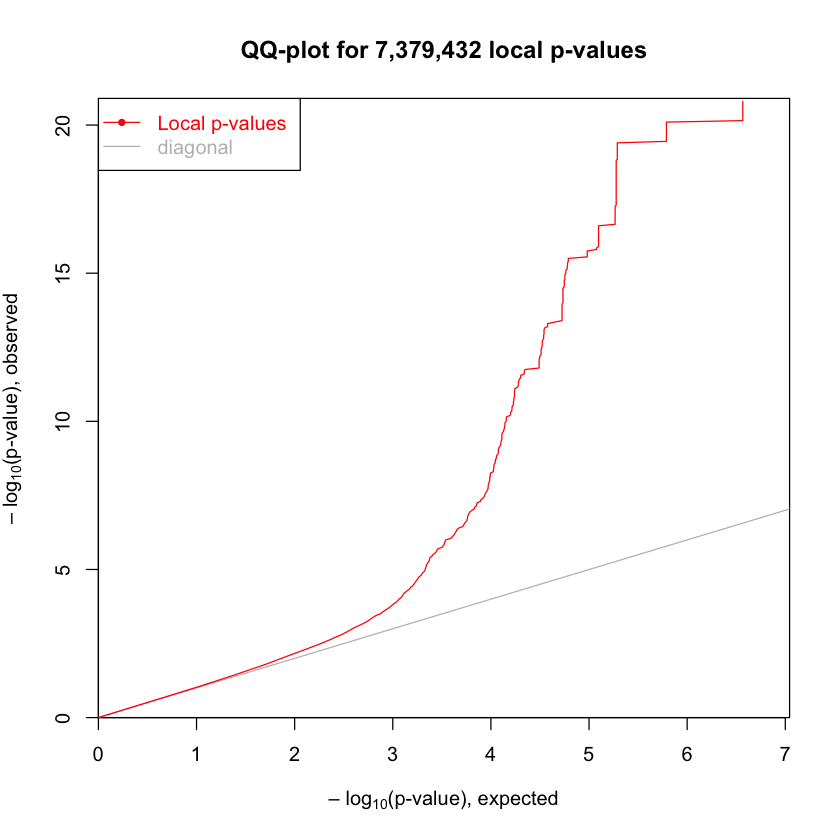

In [64]:
# MatrixEQTL saved the cis eQTL summary statistics to disk but it also saved important infomation in the "me" variable
# what class variable is it?
# Check what values are stored in there
class(me)
names(me)
names(me$cis)

# Make Q-Q plot
plot(me)

---
#### Questions Part 5.

  1. How many tests did we perform ? How many eGenes (Genes with at least one sig. SNP) and eQTLs do we have ? NOTE: here we consider a p-value < 5e-8 as statistically significant.
  2. Retrieve the best eQTL per Gene.
  3. If we set the parameter trans.thresh = 1,i.e.  save all trans eQTL results, how many trans eQTL test would have MatrixEQTL performed?

In [ ]:
#.1 TYPE YOUR RESPONSE HERE

In [65]:
# 1.
paste('Number of cis-tests: ', me$cis$ntests)
paste('Number of eGenes:', sum(me$cis$min.pv.gene < 5e-8))
paste('Number of eqtls: ', me$cis$neqtls)


[1] "Number of cis-tests:  7379432"

[1] "Number of eGenes: 31"

[1] "Number of eqtls:  943"

In [66]:
# 2.
# Manually extract the minimum p-value for each gene
eqtls <- read.table(file.path("output", cisFileName), header = T)

eqtls %>%
  group_by(gene) %>%
  slice(which.min(p.value))



SNP,gene,beta,t.stat,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>
1_171083276_A_T,ENSG00000007933.8,2.5171061,7.176077,2.497086e-10
1_40203220_G_T,ENSG00000084072.12,0.7000231,7.930061,7.826228e-12
1_110266243_C_T,ENSG00000134184.8,4.2358537,6.108815,2.917690e-08
1_89382114_C_G,ENSG00000137944.12,-1.5509300,-6.194093,2.011447e-08
1_16540540_T_G,ENSG00000142632.12,0.5395258,6.284581,1.353005e-08
1_21765845_G_C,ENSG00000142794.14,0.5940358,8.259646,1.697547e-12
1_63993153_T_C,ENSG00000142856.12,-0.5604917,-7.540367,4.719998e-11
1_159810647_G_A,ENSG00000162723.5,-2.4368220,-6.191486,2.034503e-08
1_147129453_T_C,ENSG00000162836.7,0.2759561,6.969521,6.373219e-10


In [67]:
# 3.
paste('Number of trans-tests:', nrow(snps)*nrow(ge))


[1] "Number of trans-tests: 915372315"

In [69]:
# Do the numbers match the ones reported by matrixEQTL?

paste('Number of eGenes: ', length(unique(eqtls$gene)))
paste('Number of eqtls: ', nrow(eqtls))


[1] "Number of eGenes:  31"

[1] "Number of eqtls:  943"

In [70]:
# Why do you think the following result gives a different number of eQTLs?
paste('Number of eqtls: ', sum(me$cis$min.pv.snps < 5e-8))


[1] "Number of eqtls:  923"

In [81]:
head(eqtls)
signifSNP <- eqtls %>%
    dplyr::filter(p.value < 5e-8) %>%
    pull(SNP)

paste('N. duplicated SNPs: ', sum(duplicated(signifSNP)))

,SNP,gene,beta,t.stat,p.value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1_1342712_G_T,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08
2,1_1345274_A_G,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08
3,1_1346312_A_G,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08
4,1_1346749_T_A,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08
5,1_1347258_G_C,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08
6,1_1349075_G_T,ENSG00000235098.4,-1.639674,-6.001124,4.654968e-08


[1] "N. duplicated SNPs:  20"

---
# Further exploration


- Next, make a histogram for the distance of cis-eQTLs from the TSS of the canditate Gene.

,SNP,gene,beta,t.stat,p.value,SNP_pos,gene_pos,dist.to.tss
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1_1342712_G_T,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08,1342712,1357148,14436
2,1_1345274_A_G,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08,1345274,1357148,11874
3,1_1346312_A_G,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08,1346312,1357148,10836
4,1_1346749_T_A,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08,1346749,1357148,10399
5,1_1347258_G_C,ENSG00000235098.4,-1.664835,-6.026790,4.165634e-08,1347258,1357148,9890
6,1_1349075_G_T,ENSG00000235098.4,-1.639674,-6.001124,4.654968e-08,1349075,1357148,8073


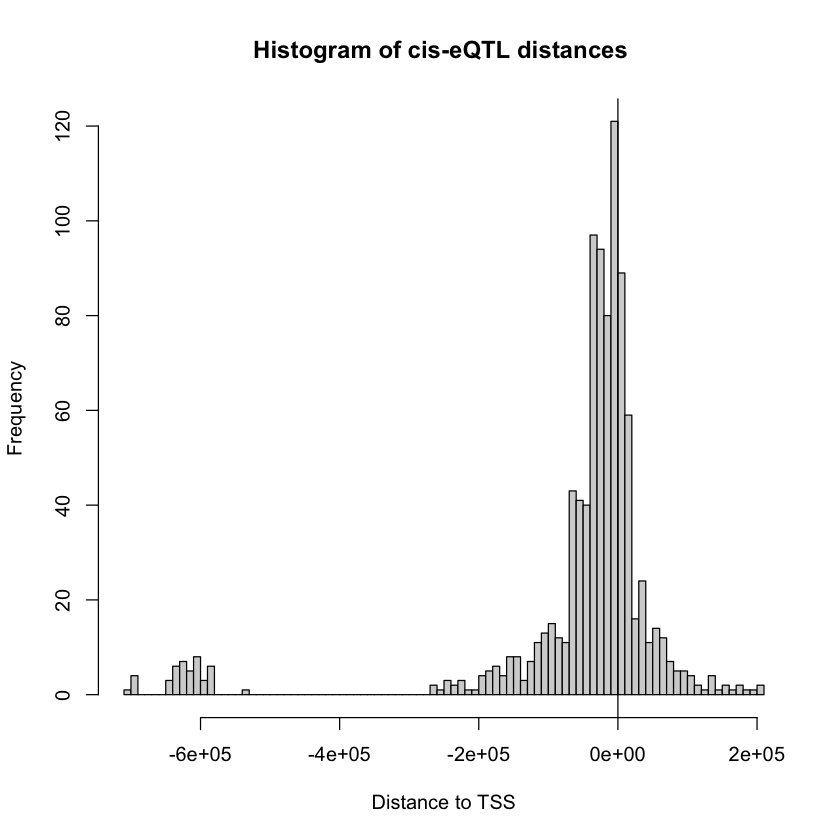

In [82]:
# Distance to TSS.
eqtls.tss <- eqtls %>%
                left_join(., snp.loc[,-2], by=c("SNP"="SNP_ID")) %>% # merge MatrixEQTL summary stats with SNP location
                rename("SNP_pos"="pos") %>%
                left_join(., gene.loc[,c(1,3)], by="gene") %>% # now also add gene location
                rename("gene_pos"="start") %>%
                mutate(dist.to.tss=gene_pos-SNP_pos) # calculate TSS distance
head(eqtls.tss)

hist(eqtls.tss$dist.to.tss, breaks = 100, main = 'Histogram of cis-eQTL distances ' , xlab = 'Distance to TSS')
abline(v=0)


- As we expected most of the signals are clustereed around the TSS of the Gene.


Now, let's retrieve the best eQTL (the one with the smallest p-value) for the eGene with the most findings.

In [83]:
# Best eQTL for the Gene with most findings.
eqtls %>% 
    group_by(gene) %>% 
    summarise(n.eqtls = n()) %>% 
    arrange(desc(n.eqtls))



gene,n.eqtls
<chr>,<int>
ENSG00000198468.3,163
ENSG00000236624.4,149
ENSG00000142794.14,87
ENSG00000226251.1,87
ENSG00000272030.1,84
ENSG00000231365.1,57
ENSG00000142856.12,46
ENSG00000218510.3,36
ENSG00000084072.12,26


In [84]:
top.signal <- eqtls %>% 
                dplyr::filter(gene == 'ENSG00000198468.3') %>%  
                slice(which.min(p.value))
head(top.signal)

,SNP,gene,beta,t.stat,p.value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1_213014465_G_A,ENSG00000198468.3,0.1928299,9.034383,4.599992e-14


- Visualize the effect of the best eQTL for the ENSG00000198468.3 Gene.

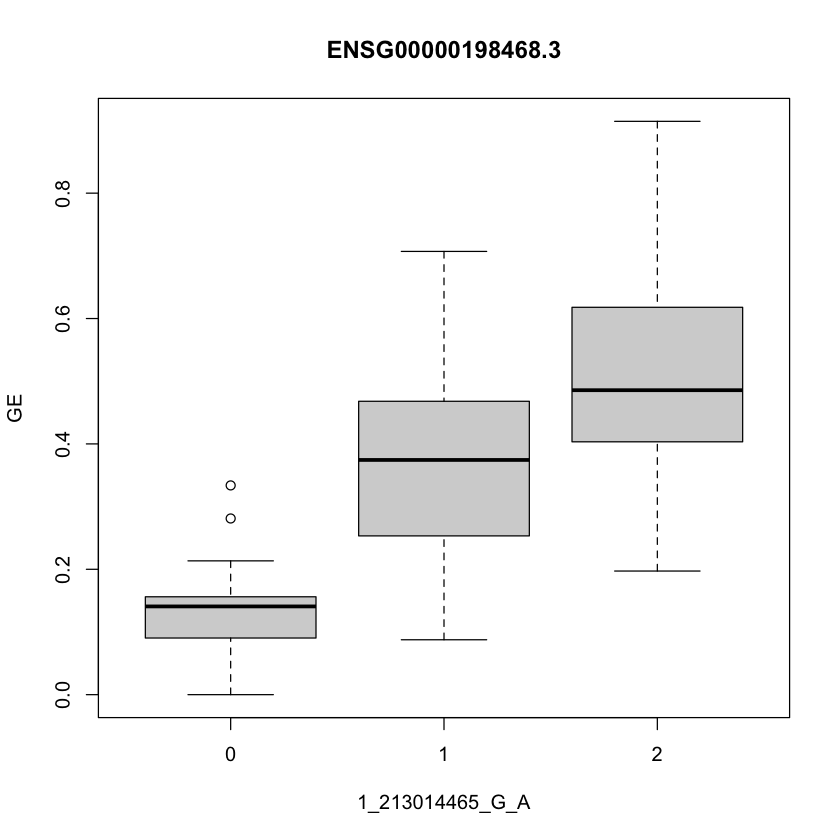

In [85]:
# Boxplot for the best eQTL.
plot.data <- snps %>% 
                dplyr::filter(rownames(snps) == top.signal$SNP)

plot.data = as.data.frame(t(plot.data))

plot.data = cbind(plot.data, ge[rownames(ge) == top.signal$gene,]) # add gene expression


boxplot(as.numeric(plot.data[[2]]) ~ as.factor(as.character(plot.data[[1]])), xlab = "1_213014465_G_A",
   ylab = "GE", main = "ENSG00000198468.3")

---
